In [1]:
import numpy as np
import torch
import pyepo

# random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
grid = (5,5) # grid size
num_data = 100 # number of training data
num_feat = 5 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.shortestpath.genData(num_data+100+1000, num_feat, grid, deg, e, seed=42)

In [3]:
from pyepo.model.grb import shortestPathModel
# set solver
optmodel = shortestPathModel(grid)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
for i, e in enumerate(optmodel.arcs):
    if sol[i] > 1e-3:
        print(e)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-01
Obj: 3.720282795993131
(0, 5)
(5, 6)
(6, 7)
(7, 8)
(8, 13)
(13, 14)
(14, 19)
(19, 24)


In [4]:
# split data
from sklearn.model_selection import train_test_split
feats, x_test, costs, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
x_train, x_val, c_train, c_val = train_test_split(feats, costs, test_size=100, random_state=42)

In [5]:
from dataset import optDatasetConstrs
# get training, validation and test dataset
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_val = pyepo.data.dataset.optDataset(optmodel, x_val, costs=c_val)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1075.36it/s]


Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1078.92it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 999.81it/s]


In [6]:
# get training and test data set without costs
dataset_train = optDatasetConstrs(optmodel, x_train, sols=dataset_train_cost.sols)

Obtaining constraints for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 722.41it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, (grid[0]-1)*grid[1]+(grid[1]-1)*grid[0])

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt
def plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-10, num_epochs+10)
    plt.ylim(0, 0.8)
    plt.xticks(range(0, num_epochs+1, 50), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
import time
from tqdm import tqdm
from earlystop import earlyStopper

def train(reg, loss_func, lr, num_epochs, log_step):
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set stopper
    stopper = earlyStopper(patience=3)
    # init log
    loss_log = []
    regret_log_trn = []
    regret_log_val = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # eval & log
        if epoch % log_step == 0:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
            regret_log_val.append(regret_val)
            tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                       format(epoch, regret_trn*100, regret_val*100))
            # early stop
            if stopper.stop(regret_val):
                print("Early Stop!")
                break
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            x, w, t_ctr = data
            # forward pass
            cp = reg(x)
            loss = loss_func(cp, t_ctr)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    # regret
    regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
    regret_log_trn.append(regret_trn)
    regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
    regret_log_val.append(regret_val)
    tbar.write("Epoch {:3}, Loss: {:8.4f}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
               format(epoch, loss.item(), regret_trn*100, regret_val*100))
    print()
    print("Evaluation:")
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, regret_log_trn, regret_log_val

### 2-Stage 

In [11]:
# init model
reg = LinearRegression()

In [12]:
from torch import nn
# init loss
mse = nn.MSELoss()

In [13]:
lr = 1e-2
num_epochs = 200
log_step = 20
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
# set stopper
stopper = earlyStopper(patience=3)
# init log
loss_log = []
regret_log_trn = []
regret_log_val = []
# running time
elapsed = 0
tbar = tqdm(range(num_epochs))
for epoch in tbar:
    # eval & log
    if epoch % log_step == 0:
        # regret
        regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
        regret_log_trn.append(regret_trn)
        regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
        regret_log_val.append(regret_val)
        tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                   format(epoch, regret_trn*100, regret_val*100))
        # early stop
        if stopper.stop(regret_val):
            print("Early Stop!")
            break
    # training
    time.sleep(1)
    tick = time.time()
    for data in loader_train_cost:
        x, c, w, z = data
        # forward pass
        cp = reg(x)
        loss = mse(cp, c)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
    # record time
    tock = time.time()
    elapsed += tock - tick
# regret
regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
regret_log_trn.append(regret_trn)
regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
regret_log_val.append(regret_val)
tbar.write("Epoch {:3}, Loss: {:8.4f}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
           format(epoch, loss.item(), regret_trn*100, regret_val*100))
print()
print("Evaluation:")
test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
print("Test Regret: {:.4f}%".format(test_regret*100))
print("Training Elapsed Time: {:.2f} Sec".format(elapsed))

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Epoch   0, Train Regret:  68.1897%, Val Regret:  62.8446%


 10%|████████                                                                         | 20/200 [00:21<03:02,  1.01s/it]

Epoch  20, Train Regret:  12.1980%, Val Regret:  15.9868%


 20%|████████████████▏                                                                | 40/200 [00:42<02:41,  1.01s/it]

Epoch  40, Train Regret:   7.4701%, Val Regret:  10.5816%


 30%|████████████████████████▎                                                        | 60/200 [01:02<02:21,  1.01s/it]

Epoch  60, Train Regret:   8.0099%, Val Regret:  10.5806%


 40%|████████████████████████████████▍                                                | 80/200 [01:23<02:01,  1.01s/it]

Epoch  80, Train Regret:   7.5767%, Val Regret:  10.7275%


 50%|████████████████████████████████████████                                        | 100/200 [01:43<01:43,  1.04s/it]


Epoch 100, Train Regret:   7.2126%, Val Regret:  10.8250%
Early Stop!
Epoch 100, Loss:   0.1313, Train Regret:   7.2126%, Val Regret:  10.8250%

Evaluation:
Test Regret: 10.1851%
Training Elapsed Time: 1.56 Sec


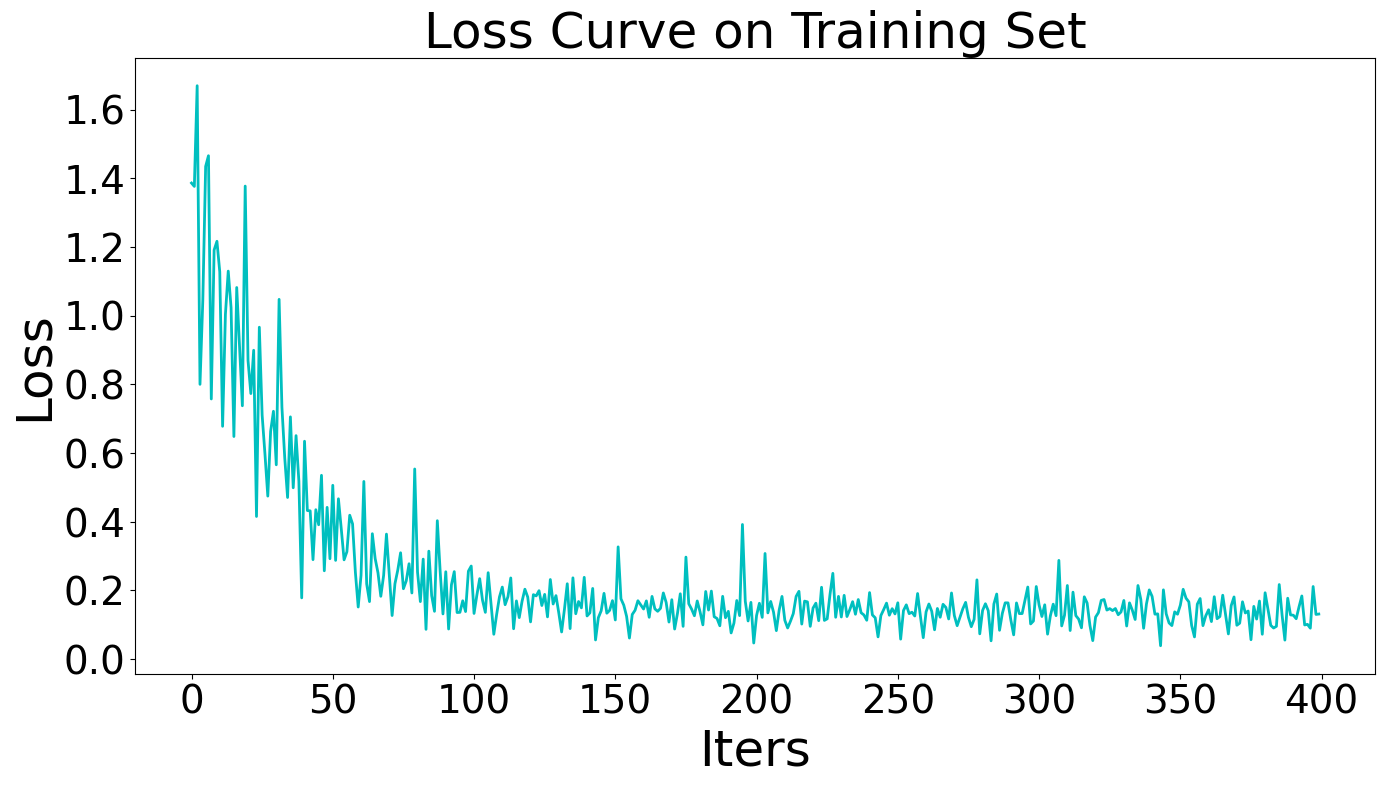

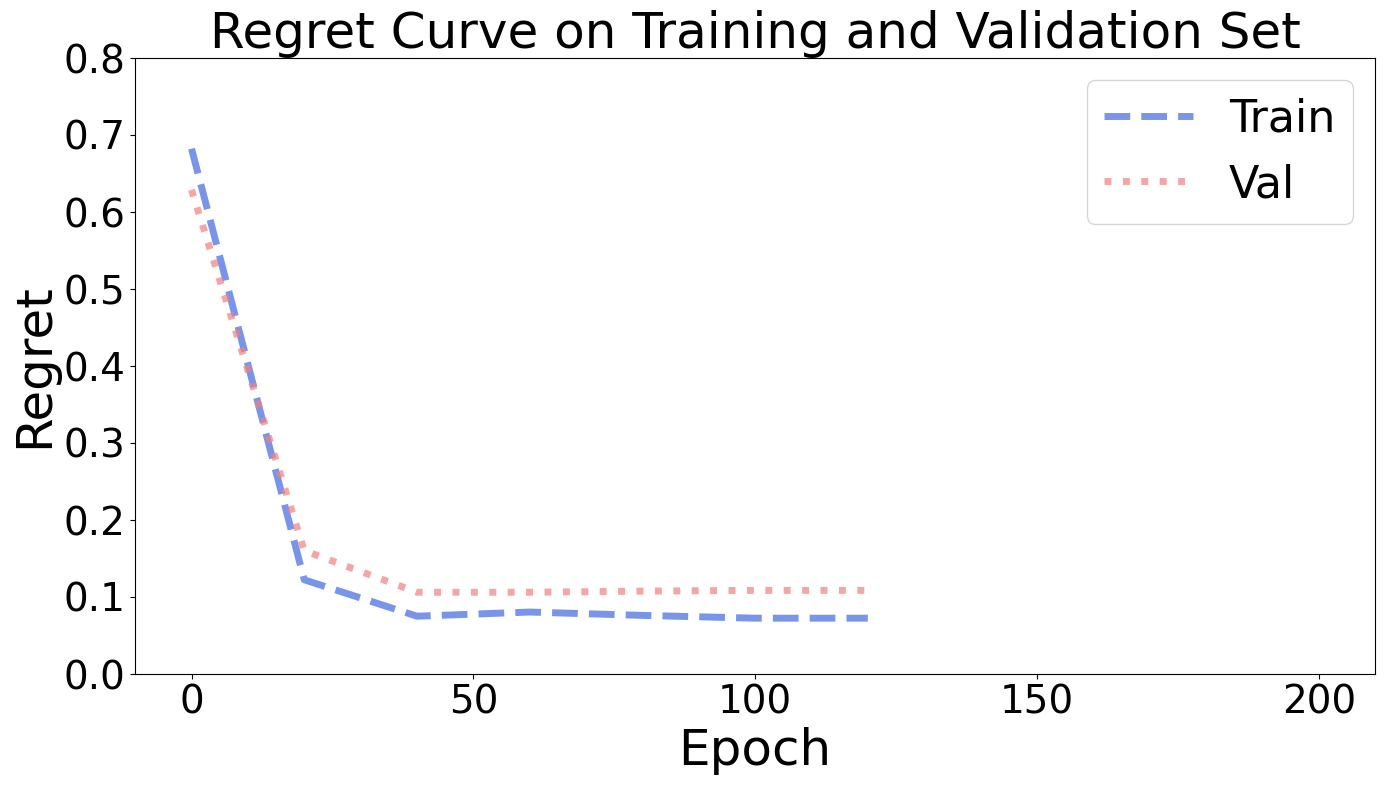

In [14]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Exact Method 

In [15]:
# init model
reg = LinearRegression()

In [16]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, warmstart=True, conecheck=True, processes=8)

Num of cores: 8


In [17]:
lr = 1e-2
num_epochs = 200
log_step = 20
loss_log, regret_log_trn, regret_log_val = train(reg, ca_cos, lr, num_epochs, log_step)

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Epoch   0, Train Regret:  55.4387%, Val Regret:  50.0488%


Epoch   19, Loss:  -0.9990:  10%|█████▎                                               | 20/200 [00:28<03:38,  1.22s/it]

Epoch  20, Train Regret:  14.4658%, Val Regret:  17.6052%


Epoch   39, Loss:  -0.9994:  20%|██████████▌                                          | 40/200 [00:52<03:13,  1.21s/it]

Epoch  40, Train Regret:  16.0932%, Val Regret:  15.4579%


Epoch   59, Loss:  -0.9999:  30%|███████████████▉                                     | 60/200 [01:17<02:50,  1.22s/it]

Epoch  60, Train Regret:  14.0088%, Val Regret:  13.0108%


Epoch   79, Loss:  -1.0000:  40%|█████████████████████▏                               | 80/200 [01:41<02:25,  1.21s/it]

Epoch  80, Train Regret:  13.1736%, Val Regret:  12.7891%


Epoch   99, Loss:  -1.0000:  50%|██████████████████████████                          | 100/200 [02:06<02:02,  1.22s/it]

Epoch 100, Train Regret:  12.7564%, Val Regret:  12.6881%


Epoch  119, Loss:  -1.0000:  60%|███████████████████████████████▏                    | 120/200 [02:31<01:36,  1.21s/it]

Epoch 120, Train Regret:  12.7144%, Val Regret:  12.7287%


Epoch  139, Loss:  -1.0000:  70%|████████████████████████████████████▍               | 140/200 [02:55<01:12,  1.21s/it]

Epoch 140, Train Regret:  15.4291%, Val Regret:  14.1938%


Epoch  159, Loss:  -1.0000:  80%|█████████████████████████████████████████▌          | 160/200 [03:20<00:50,  1.25s/it]


Epoch 160, Train Regret:  13.0413%, Val Regret:  15.7458%
Early Stop!
Epoch 160, Loss:  -1.0000, Train Regret:  13.0413%, Val Regret:  15.7458%

Evaluation:
Test Regret: 16.6030%
Training Elapsed Time: 36.10 Sec


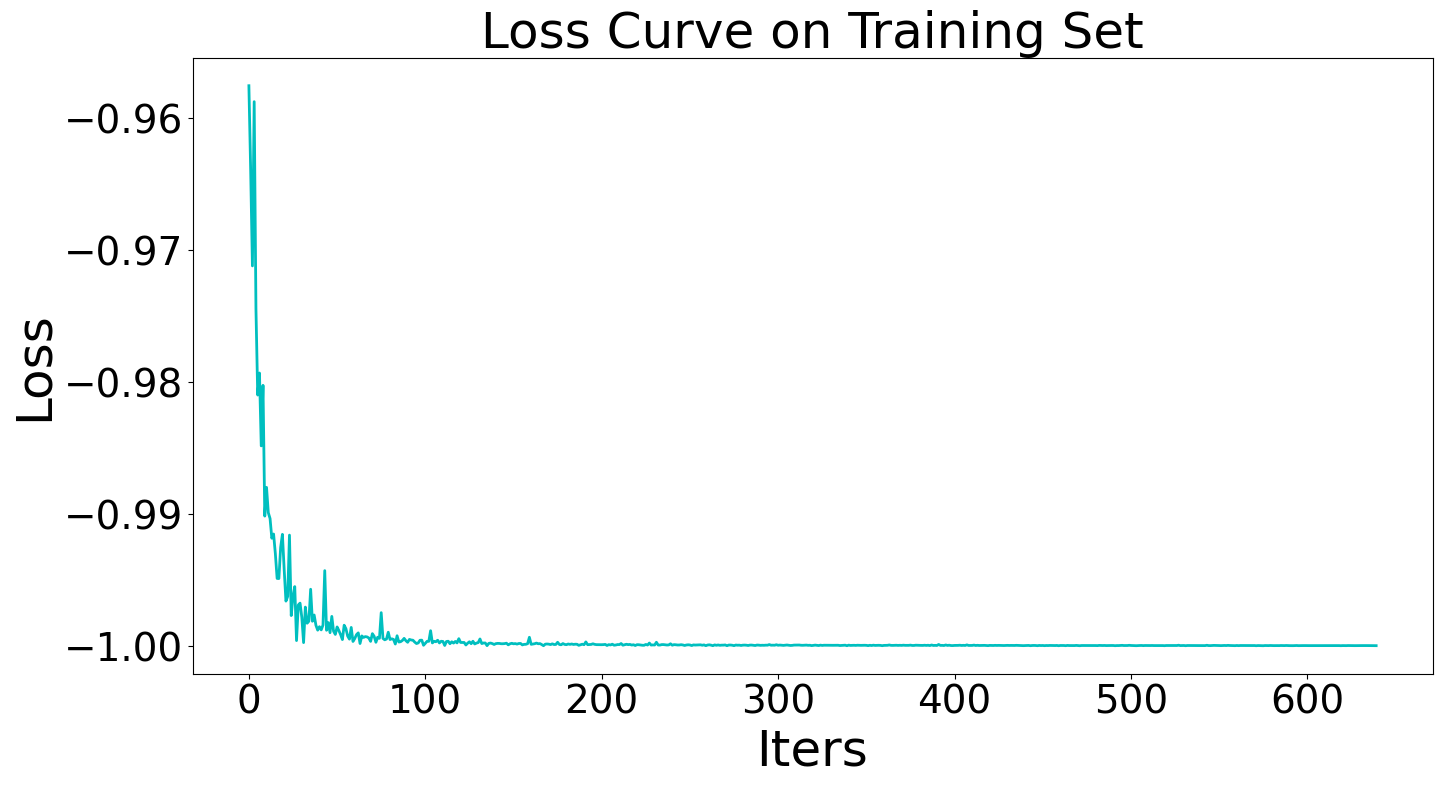

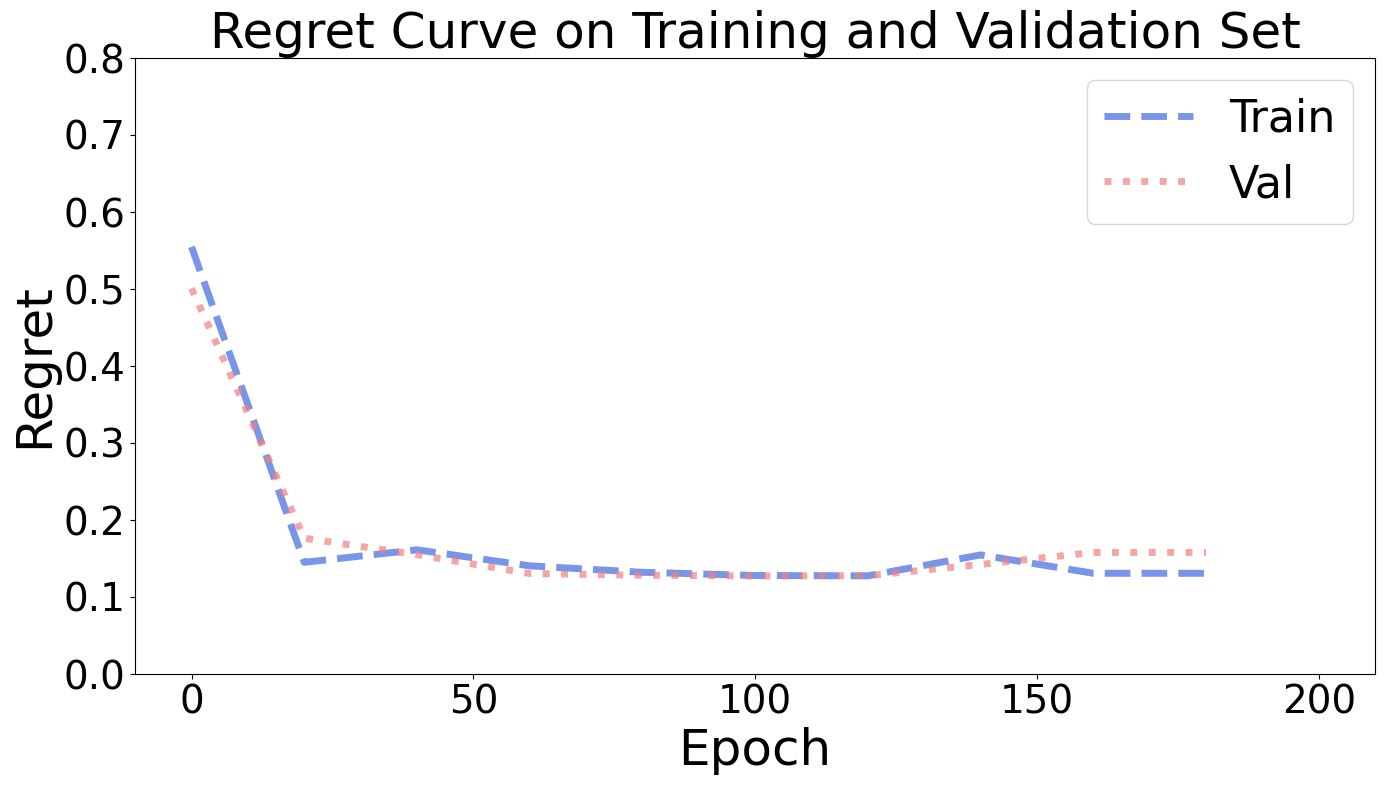

In [18]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### NNLS Method

In [19]:
# init model
reg = LinearRegression()

In [20]:
from func import nnlsConeAlignedCosine
# init loss
ca_cos = nnlsConeAlignedCosine(optmodel, conecheck=False, processes=1)

Num of cores: 1


In [21]:
lr = 1e-2
num_epochs = 200
log_step = 20
loss_log, regret_log_trn, regret_log_val = train(reg, ca_cos, lr, num_epochs, log_step)

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Epoch   0, Train Regret:  46.4773%, Val Regret:  50.7665%


Epoch   19, Loss:  -0.9995:  10%|█████▎                                               | 20/200 [00:21<03:08,  1.05s/it]

Epoch  20, Train Regret:  12.7916%, Val Regret:  20.6997%


Epoch   39, Loss:  -1.0000:  20%|██████████▌                                          | 40/200 [00:42<02:47,  1.05s/it]

Epoch  40, Train Regret:  14.9485%, Val Regret:  15.3320%


Epoch   59, Loss:  -1.0000:  30%|███████████████▉                                     | 60/200 [01:03<02:26,  1.04s/it]

Epoch  60, Train Regret:  15.1470%, Val Regret:  16.6407%


Epoch   79, Loss:  -0.9998:  40%|█████████████████████▏                               | 80/200 [01:25<02:05,  1.04s/it]

Epoch  80, Train Regret:  13.3289%, Val Regret:  15.9968%


Epoch   99, Loss:  -1.0000:  50%|██████████████████████████                          | 100/200 [01:46<01:44,  1.04s/it]

Epoch 100, Train Regret:  16.1084%, Val Regret:  14.0758%


Epoch  119, Loss:  -1.0000:  60%|███████████████████████████████▏                    | 120/200 [02:07<01:23,  1.05s/it]

Epoch 120, Train Regret:  14.6209%, Val Regret:  14.2883%


Epoch  139, Loss:  -1.0000:  70%|████████████████████████████████████▍               | 140/200 [02:28<01:02,  1.04s/it]

Epoch 140, Train Regret:  16.3762%, Val Regret:  16.3570%


Epoch  159, Loss:  -1.0000:  80%|█████████████████████████████████████████▌          | 160/200 [02:49<00:42,  1.06s/it]


Epoch 160, Train Regret:  10.4354%, Val Regret:  14.4166%
Early Stop!
Epoch 160, Loss:  -1.0000, Train Regret:  10.4354%, Val Regret:  14.4166%

Evaluation:
Test Regret: 14.0389%
Training Elapsed Time: 6.19 Sec


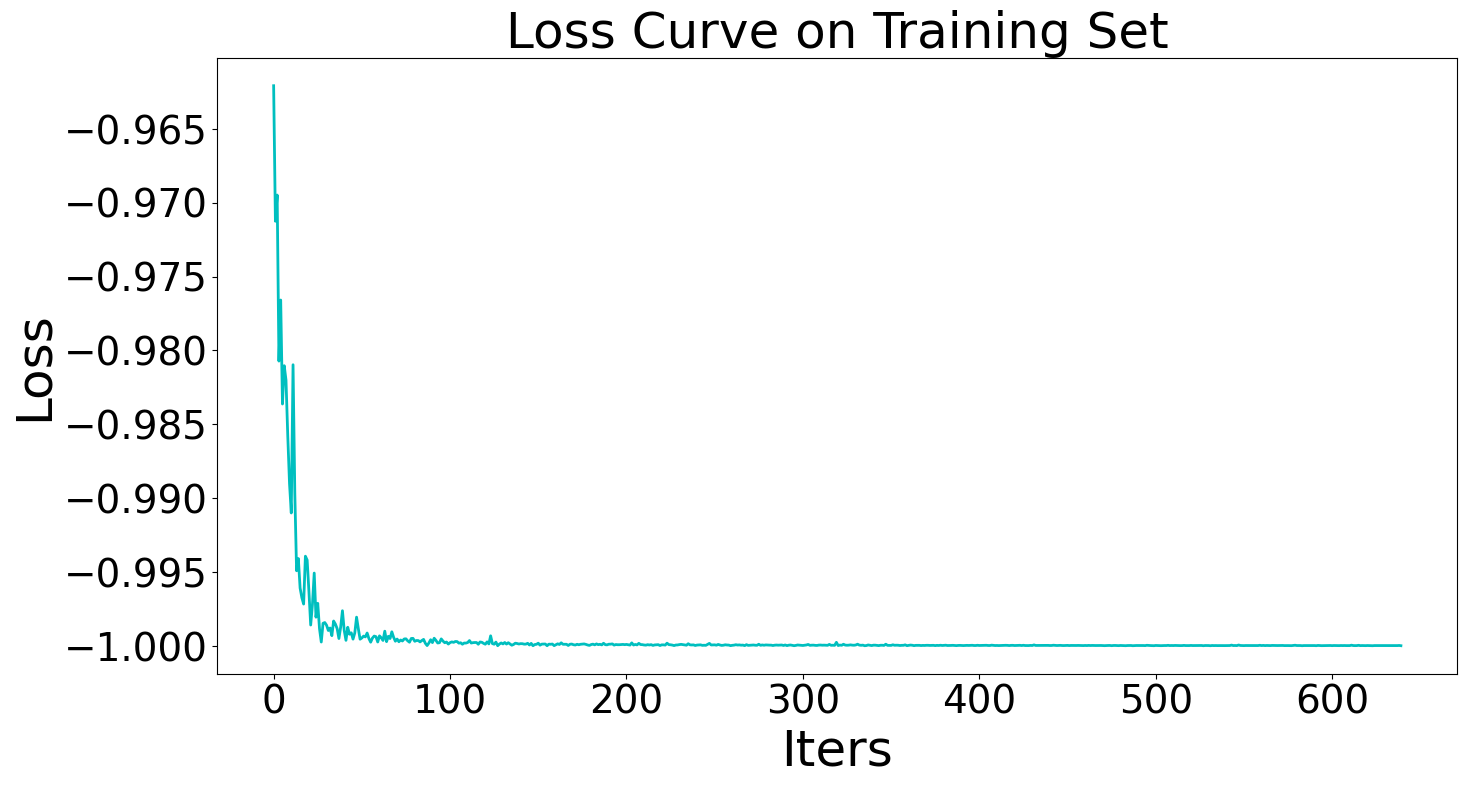

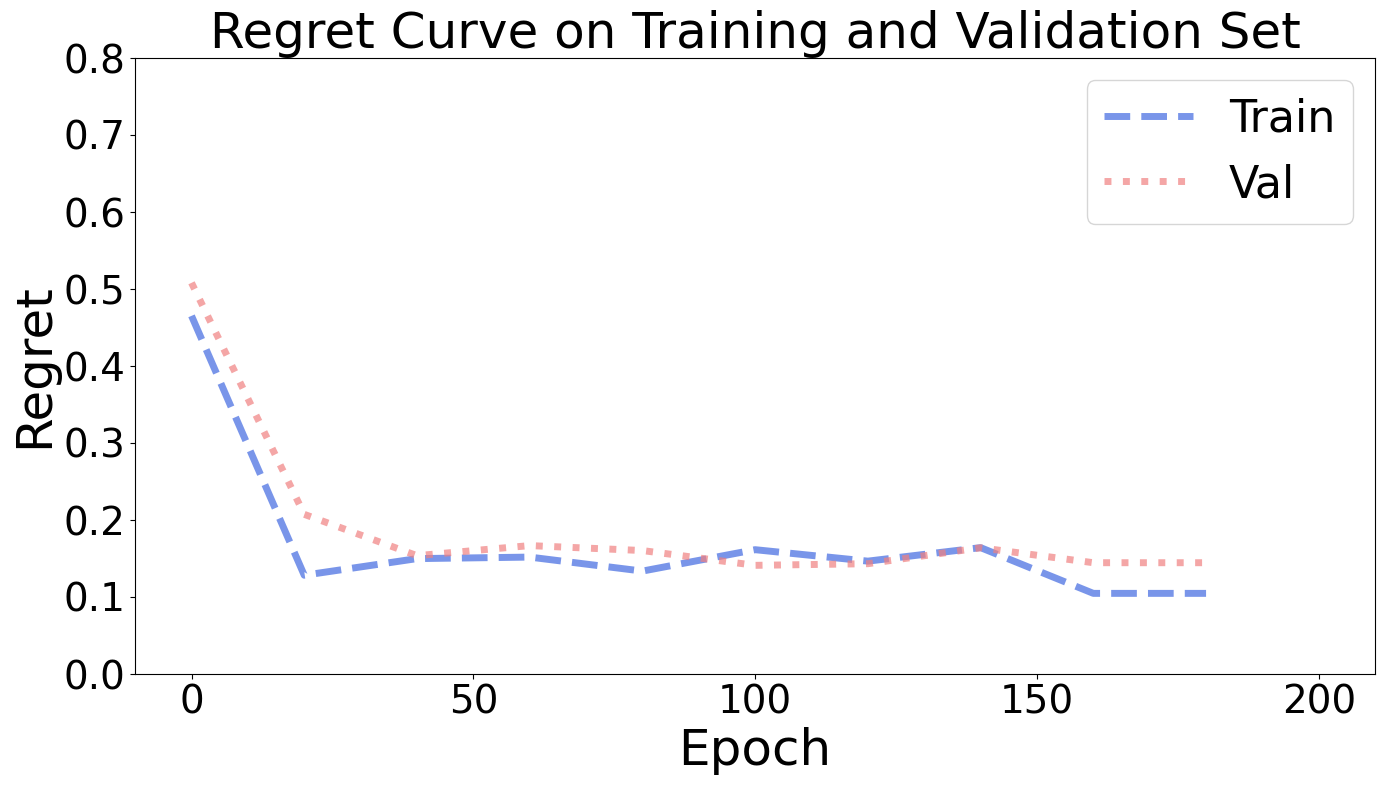

In [22]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method

In [23]:
# init model
reg = LinearRegression()

In [24]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100)

In [25]:
lr = 1e-2
num_epochs = 200
log_step = 20
loss_log, regret_log_trn, regret_log_val = train(reg, ca_cos, lr, num_epochs, log_step)

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Epoch   0, Train Regret:  57.0788%, Val Regret:  60.7046%


Epoch   19, Loss:  -0.6713:  10%|█████▎                                               | 20/200 [00:21<03:06,  1.03s/it]

Epoch  20, Train Regret:   8.6229%, Val Regret:  12.9511%


Epoch   39, Loss:  -0.6254:  20%|██████████▌                                          | 40/200 [00:42<02:45,  1.03s/it]

Epoch  40, Train Regret:   8.3684%, Val Regret:  13.7143%


Epoch   59, Loss:  -0.7025:  30%|███████████████▉                                     | 60/200 [01:03<02:24,  1.03s/it]

Epoch  60, Train Regret:   8.3590%, Val Regret:  12.3343%


Epoch   79, Loss:  -0.7126:  40%|█████████████████████▏                               | 80/200 [01:24<02:04,  1.04s/it]

Epoch  80, Train Regret:   8.6049%, Val Regret:  11.9530%


Epoch   99, Loss:  -0.6734:  50%|██████████████████████████                          | 100/200 [01:45<01:43,  1.04s/it]

Epoch 100, Train Regret:   9.1630%, Val Regret:  14.0876%


Epoch  119, Loss:  -0.7222:  60%|███████████████████████████████▏                    | 120/200 [02:06<01:22,  1.03s/it]

Epoch 120, Train Regret:   9.1302%, Val Regret:  14.1812%


Epoch  139, Loss:  -0.7198:  70%|████████████████████████████████████▍               | 140/200 [02:27<01:03,  1.05s/it]


Epoch 140, Train Regret:   9.0871%, Val Regret:  14.0208%
Early Stop!
Epoch 140, Loss:  -0.7198, Train Regret:   9.0871%, Val Regret:  14.0208%

Evaluation:
Test Regret: 14.7479%
Training Elapsed Time: 3.82 Sec


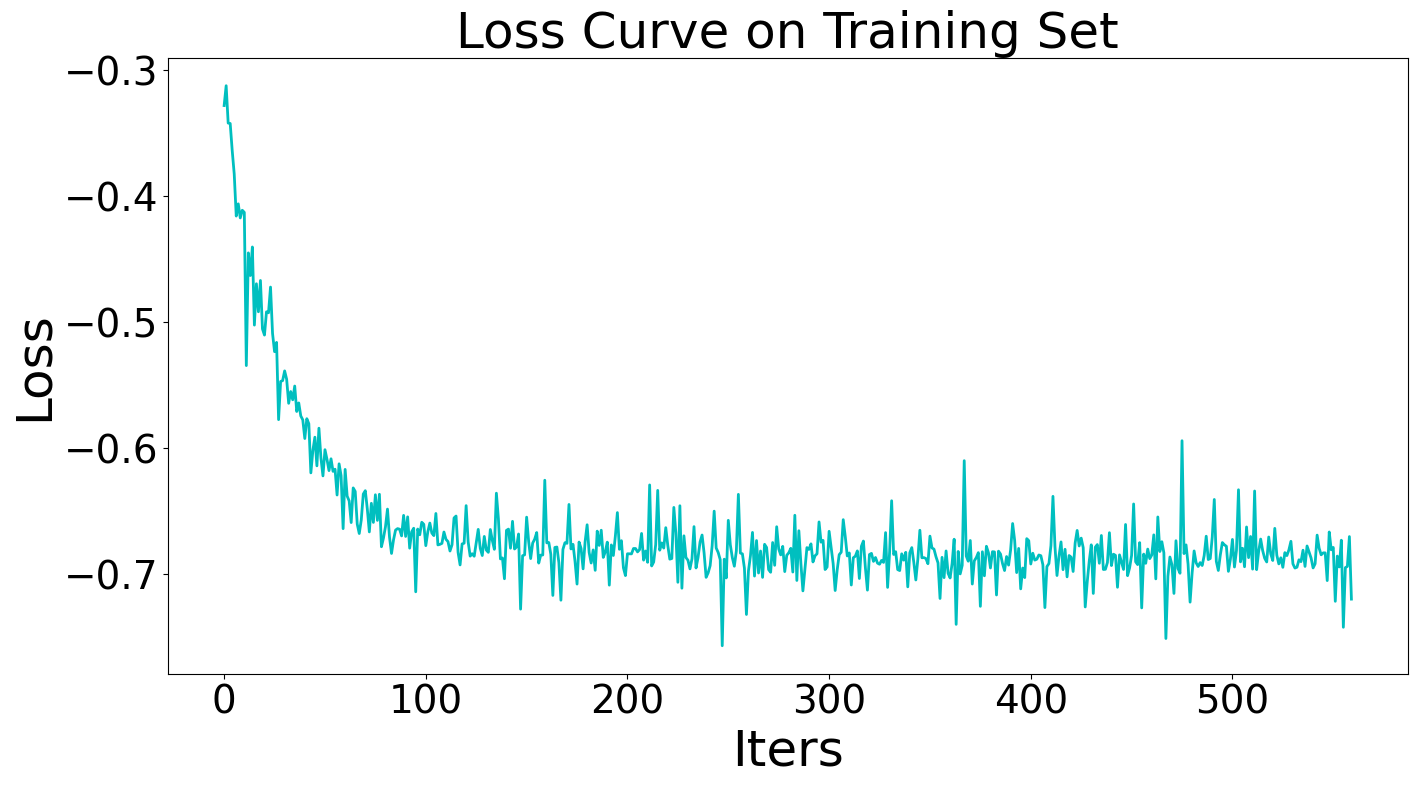

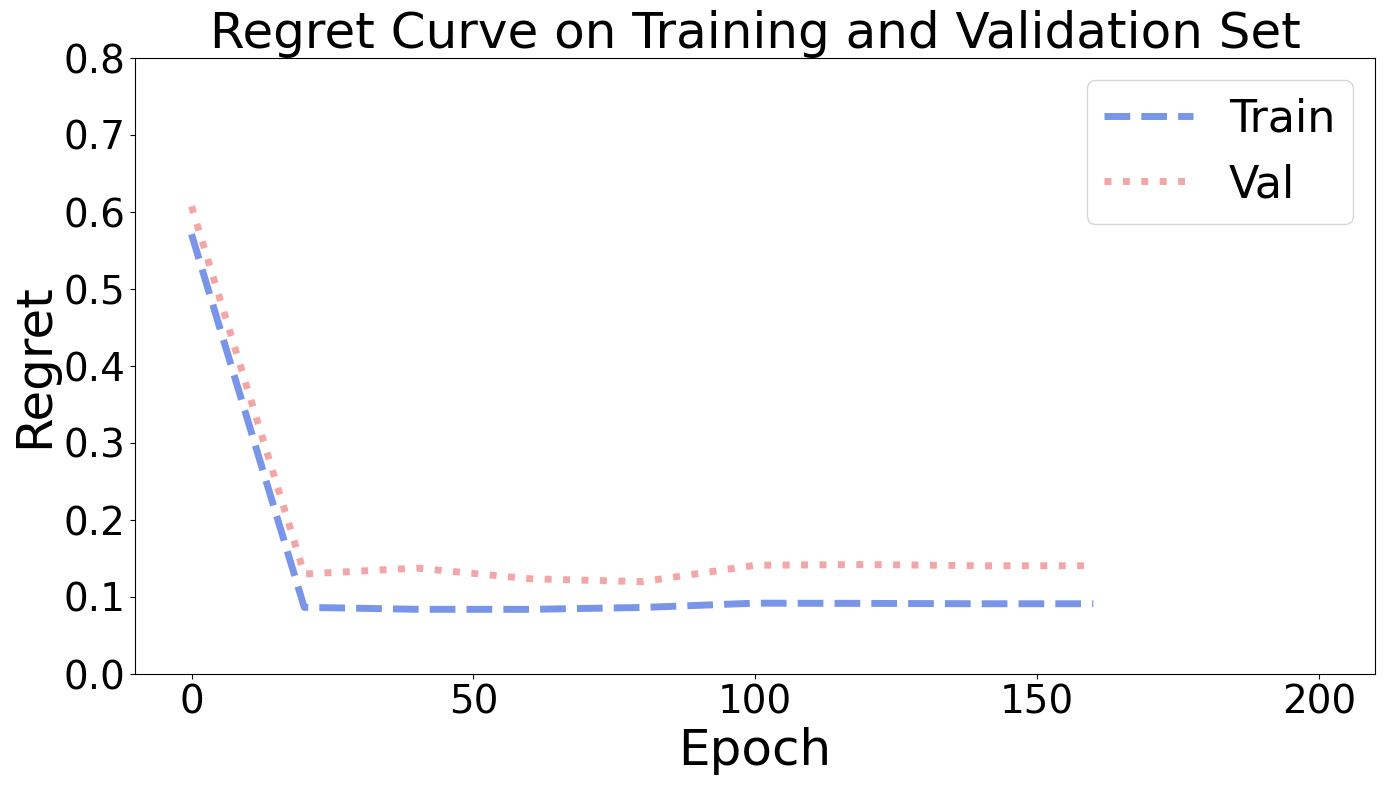

In [26]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Average Method 

In [27]:
# init model
reg = LinearRegression()

In [28]:
from func import avgVectConeAlignedCosine
# init loss
ca_cos = avgVectConeAlignedCosine(optmodel)

In [29]:
lr = 1e-2
num_epochs = 200
log_step = 20
loss_log, regret_log_trn, regret_log_val = train(reg, ca_cos, lr, num_epochs, log_step)

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Epoch   0, Train Regret:  58.7251%, Val Regret:  63.1662%


Epoch   19, Loss:  -0.8262:  10%|█████▎                                               | 20/200 [00:20<03:03,  1.02s/it]

Epoch  20, Train Regret:   8.4509%, Val Regret:  15.7253%


Epoch   39, Loss:  -0.7598:  20%|██████████▌                                          | 40/200 [00:41<02:42,  1.02s/it]

Epoch  40, Train Regret:   9.3327%, Val Regret:  12.9209%


Epoch   59, Loss:  -0.7042:  30%|███████████████▉                                     | 60/200 [01:02<02:22,  1.02s/it]

Epoch  60, Train Regret:   8.2034%, Val Regret:  13.4390%


Epoch   79, Loss:  -0.7998:  40%|█████████████████████▏                               | 80/200 [01:22<02:02,  1.02s/it]

Epoch  80, Train Regret:   7.8023%, Val Regret:  12.8230%


Epoch   99, Loss:  -0.8850:  50%|██████████████████████████                          | 100/200 [01:43<01:41,  1.01s/it]

Epoch 100, Train Regret:   8.7395%, Val Regret:  12.8503%


Epoch  119, Loss:  -0.7402:  60%|███████████████████████████████▏                    | 120/200 [02:03<01:21,  1.02s/it]

Epoch 120, Train Regret:   9.7203%, Val Regret:  13.7440%


Epoch  139, Loss:  -0.8278:  70%|████████████████████████████████████▍               | 140/200 [02:24<01:01,  1.03s/it]


Epoch 140, Train Regret:   8.8948%, Val Regret:  13.6335%
Early Stop!
Epoch 140, Loss:  -0.8278, Train Regret:   8.8948%, Val Regret:  13.6335%

Evaluation:
Test Regret: 15.1446%
Training Elapsed Time: 1.43 Sec


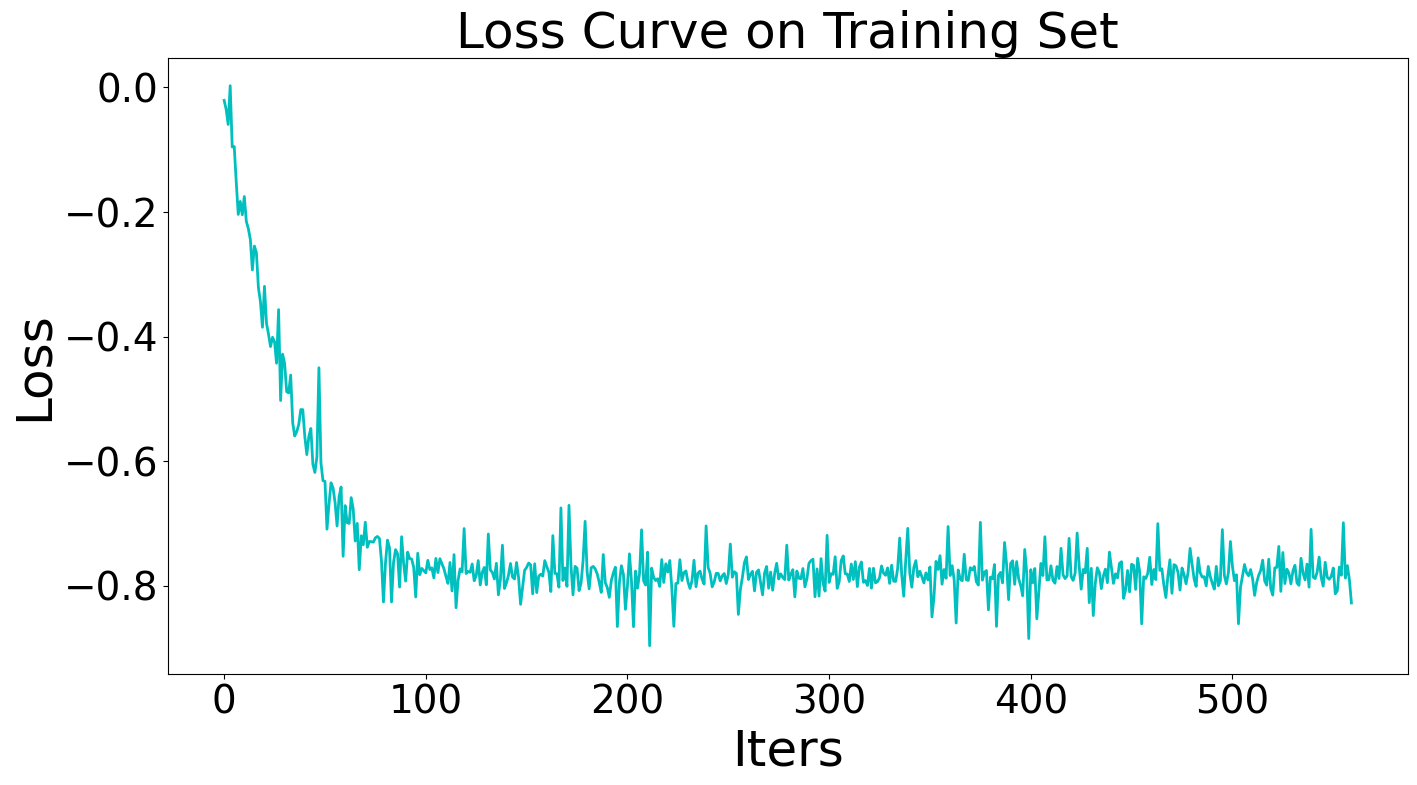

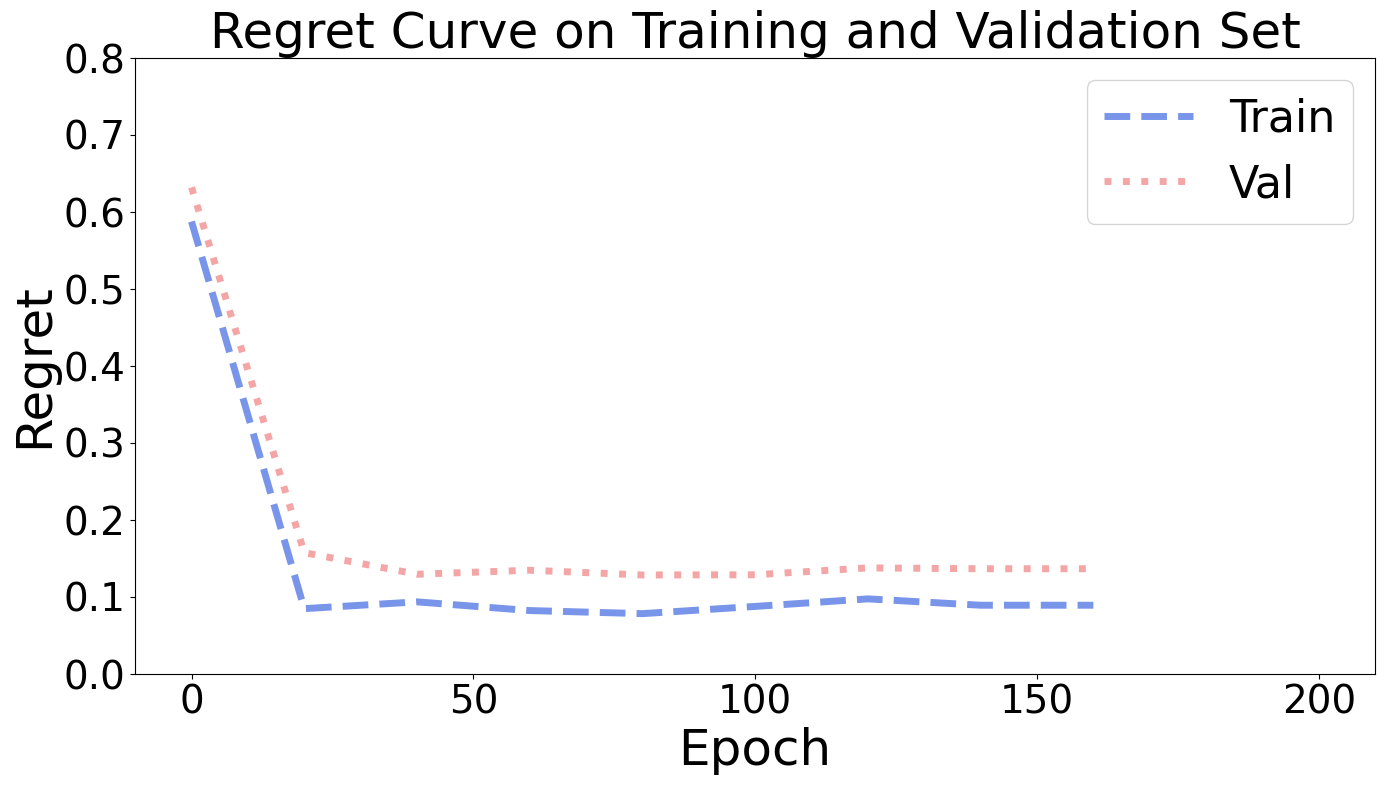

In [30]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### PFYL 

In [31]:
# init model
reg = LinearRegression()

In [32]:
from pyepo.func import perturbedFenchelYoung
# init pfyl loss
pfy = perturbedFenchelYoung(optmodel, n_samples=1, sigma=1.0, processes=8)

Num of cores: 8


In [33]:
lr = 1e-2
num_epochs = 200
log_step = 20
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
# set stopper
stopper = earlyStopper(patience=3)
# init log
loss_log = []
regret_log_trn = []
regret_log_val = []
# running time
elapsed = 0
tbar = tqdm(range(num_epochs))
for epoch in tbar:
    # eval & log
    if epoch % log_step == 0:
        # regret
        regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
        regret_log_trn.append(regret_trn)
        regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
        regret_log_val.append(regret_val)
        tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                   format(epoch, regret_trn*100, regret_val*100))
        # early stop
        if stopper.stop(regret_val):
            print("Early Stop!")
            break
    # training
    time.sleep(1)
    tick = time.time()
    for data in loader_train:
        x, w, t_ctr = data
        # forward pass
        cp = reg(x)
        loss = pfy(cp, w)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
    # record time
    tock = time.time()
    elapsed += tock - tick
# regret
regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
regret_log_trn.append(regret_trn)
regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
regret_log_val.append(regret_val)
tbar.write("Epoch {:3}, Loss: {:8.4f}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
           format(epoch, loss.item(), regret_trn*100, regret_val*100))
print()
print("Evaluation:")
test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
print("Test Regret: {:.4f}%".format(test_regret*100))
print("Training Elapsed Time: {:.2f} Sec".format(elapsed))

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Epoch   0, Train Regret:  57.3057%, Val Regret:  59.8408%


 10%|████████                                                                         | 20/200 [00:23<03:29,  1.16s/it]

Epoch  20, Train Regret:   7.8944%, Val Regret:  14.9860%


 20%|████████████████▏                                                                | 40/200 [00:47<03:06,  1.16s/it]

Epoch  40, Train Regret:   6.5874%, Val Regret:  15.2825%


 30%|████████████████████████▎                                                        | 60/200 [01:10<02:42,  1.16s/it]

Epoch  60, Train Regret:   6.1209%, Val Regret:  13.2546%


 40%|████████████████████████████████▍                                                | 80/200 [01:34<02:18,  1.16s/it]

Epoch  80, Train Regret:   5.0395%, Val Regret:  13.6095%


 50%|████████████████████████████████████████                                        | 100/200 [01:57<01:56,  1.16s/it]

Epoch 100, Train Regret:   4.6185%, Val Regret:  14.7521%


 60%|████████████████████████████████████████████████                                | 120/200 [02:21<01:33,  1.17s/it]

Epoch 120, Train Regret:   5.9364%, Val Regret:  12.4601%


 70%|████████████████████████████████████████████████████████                        | 140/200 [02:45<01:09,  1.17s/it]

Epoch 140, Train Regret:   4.9921%, Val Regret:  12.9147%


 80%|████████████████████████████████████████████████████████████████                | 160/200 [03:08<00:46,  1.16s/it]

Epoch 160, Train Regret:   5.8626%, Val Regret:  13.4795%


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [03:32<00:23,  1.18s/it]


Epoch 180, Train Regret:   5.2347%, Val Regret:  15.2903%
Early Stop!
Epoch 180, Loss:  12.0000, Train Regret:   5.2347%, Val Regret:  15.2903%

Evaluation:
Test Regret: 11.9113%
Training Elapsed Time: 27.83 Sec


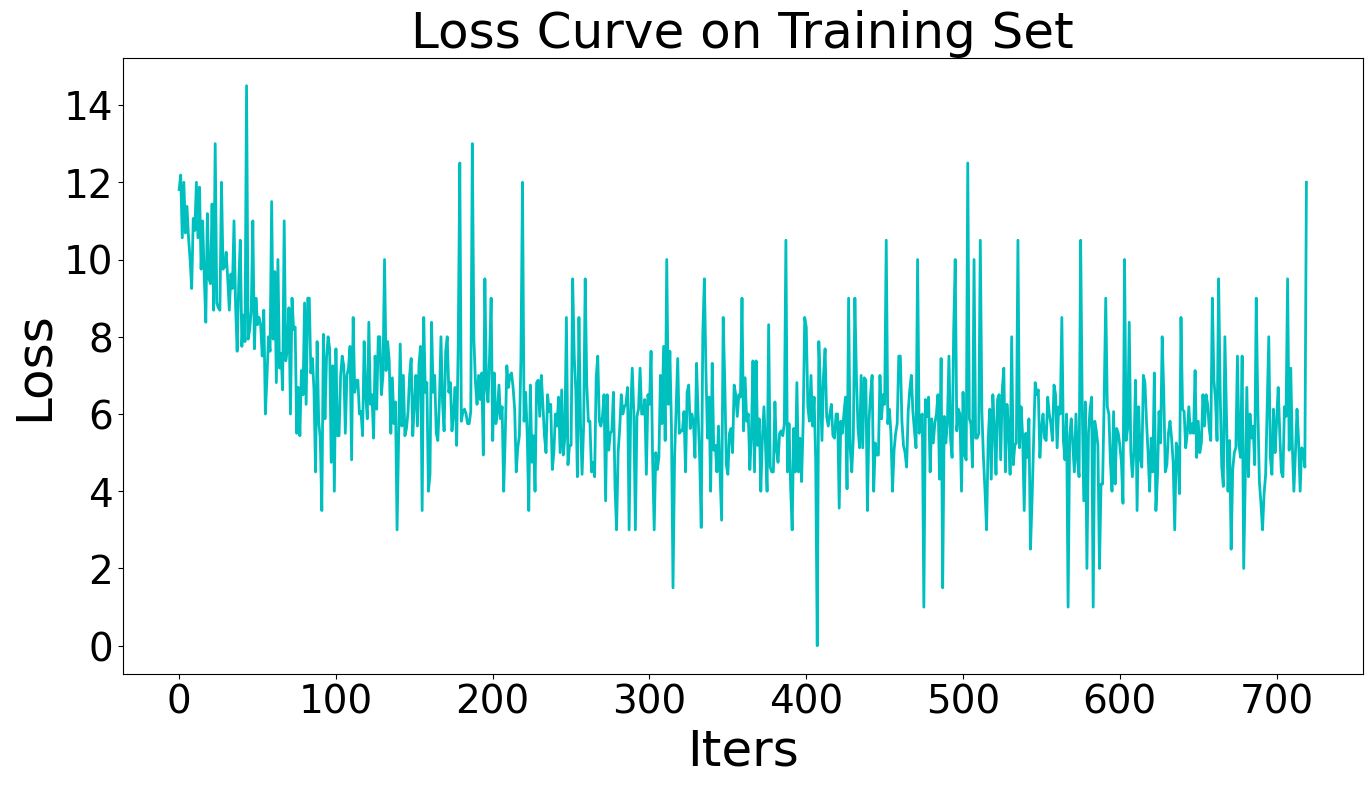

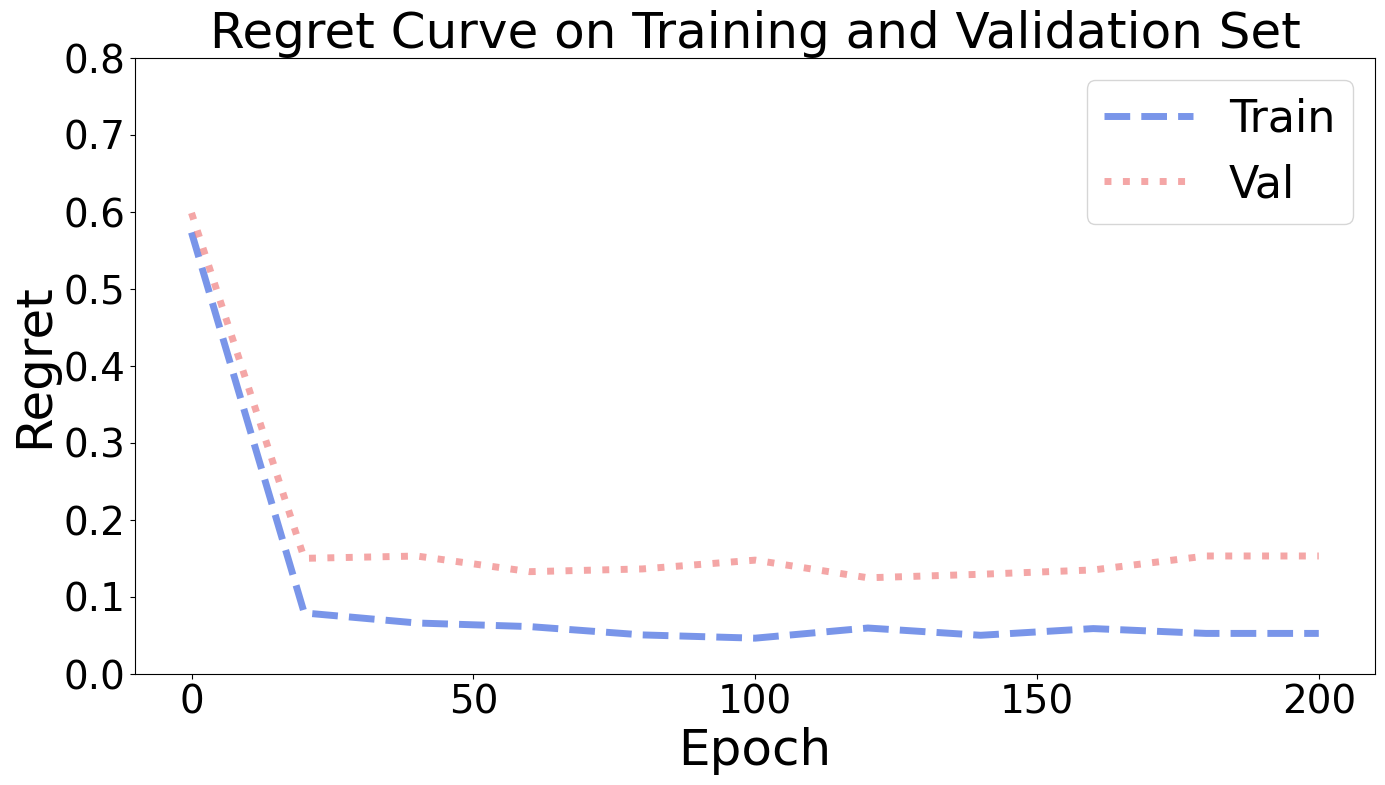

In [34]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### NCE 

In [35]:
# init model
reg = LinearRegression()

In [36]:
from pyepo.func import NCE
# init nce loss
nce = NCE(optmodel, processes=2, solve_ratio=0.05, dataset=dataset_train_cost)

Num of cores: 2


In [37]:
lr = 1e-2
num_epochs = 200
log_step = 20
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
# set stopper
stopper = earlyStopper(patience=3)
# init log
loss_log = []
regret_log_trn = []
regret_log_val = []
# running time
elapsed = 0
tbar = tqdm(range(num_epochs))
for epoch in tbar:
    # eval & log
    if epoch % log_step == 0:
        # regret
        regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
        regret_log_trn.append(regret_trn)
        regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
        regret_log_val.append(regret_val)
        tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                   format(epoch, regret_trn*100, regret_val*100))
        # early stop
        if stopper.stop(regret_val):
            print("Early Stop!")
            break
    # training
    time.sleep(1)
    tick = time.time()
    for data in loader_train:
        x, w, t_ctr = data
        # forward pass
        cp = reg(x)
        loss = nce(cp, w)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
    # record time
    tock = time.time()
    elapsed += tock - tick
# regret
regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
regret_log_trn.append(regret_trn)
regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
regret_log_val.append(regret_val)
tbar.write("Epoch {:3}, Loss: {:8.4f}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
           format(epoch, loss.item(), regret_trn*100, regret_val*100))
print()
print("Evaluation:")
test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
print("Test Regret: {:.4f}%".format(test_regret*100))
print("Training Elapsed Time: {:.2f} Sec".format(elapsed))

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Epoch   0, Train Regret:  52.8715%, Val Regret:  50.4569%


 10%|████████                                                                         | 20/200 [00:24<03:10,  1.06s/it]

Epoch  20, Train Regret:  10.6393%, Val Regret:  15.9708%


 20%|████████████████▏                                                                | 40/200 [00:45<02:41,  1.01s/it]

Epoch  40, Train Regret:  10.4663%, Val Regret:  15.8745%


 30%|████████████████████████▎                                                        | 60/200 [01:05<02:23,  1.02s/it]

Epoch  60, Train Regret:  10.6577%, Val Regret:  15.4190%


 40%|████████████████████████████████▍                                                | 80/200 [01:26<02:03,  1.03s/it]

Epoch  80, Train Regret:  10.6014%, Val Regret:  15.5288%


 50%|████████████████████████████████████████                                        | 100/200 [01:47<01:42,  1.02s/it]

Epoch 100, Train Regret:  11.1269%, Val Regret:  15.8637%


 60%|████████████████████████████████████████████████                                | 120/200 [02:07<01:25,  1.07s/it]


Epoch 120, Train Regret:  10.7630%, Val Regret:  16.3398%
Early Stop!
Epoch 120, Loss: -80.9335, Train Regret:  10.7630%, Val Regret:  16.3398%

Evaluation:
Test Regret: 15.3079%
Training Elapsed Time: 5.05 Sec


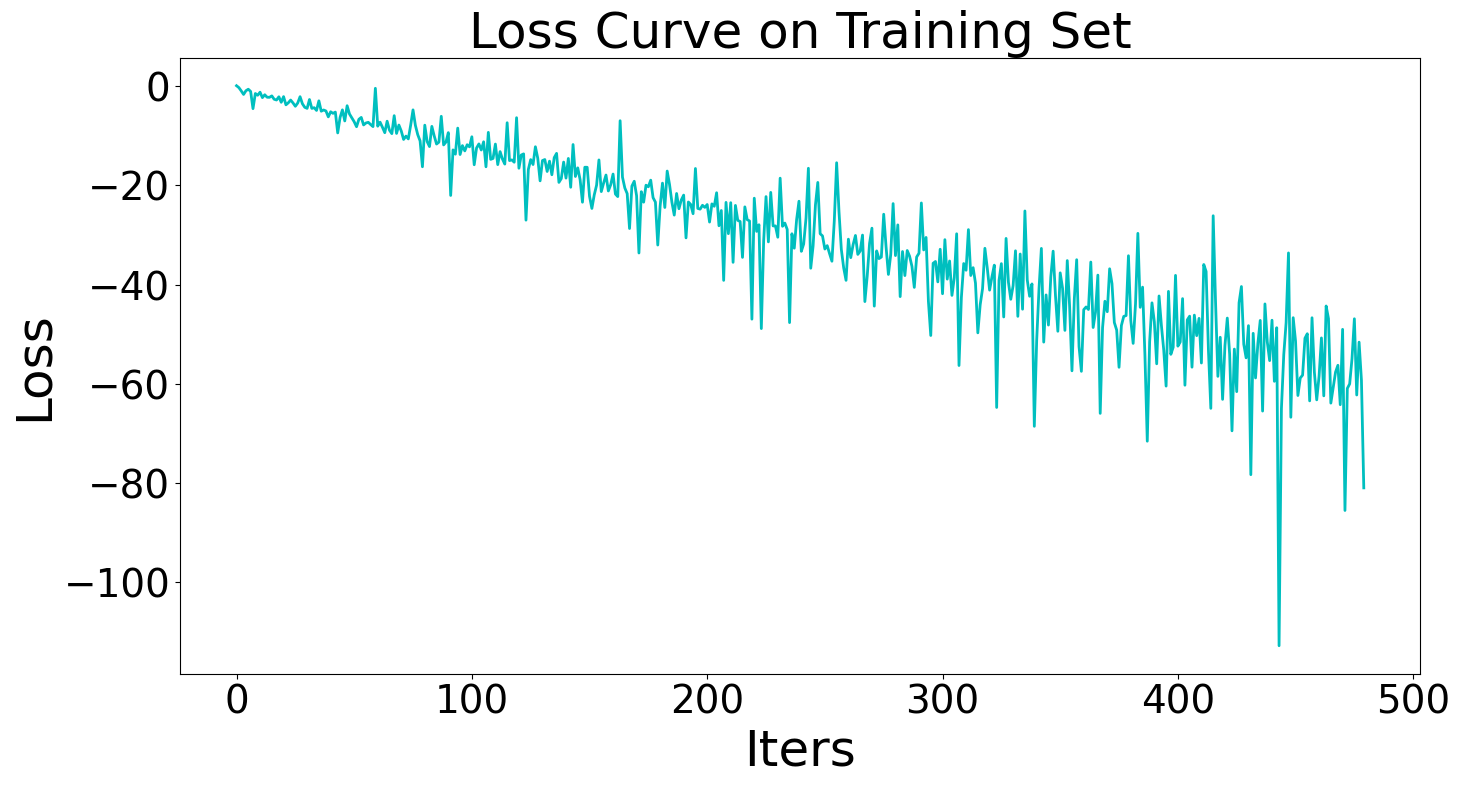

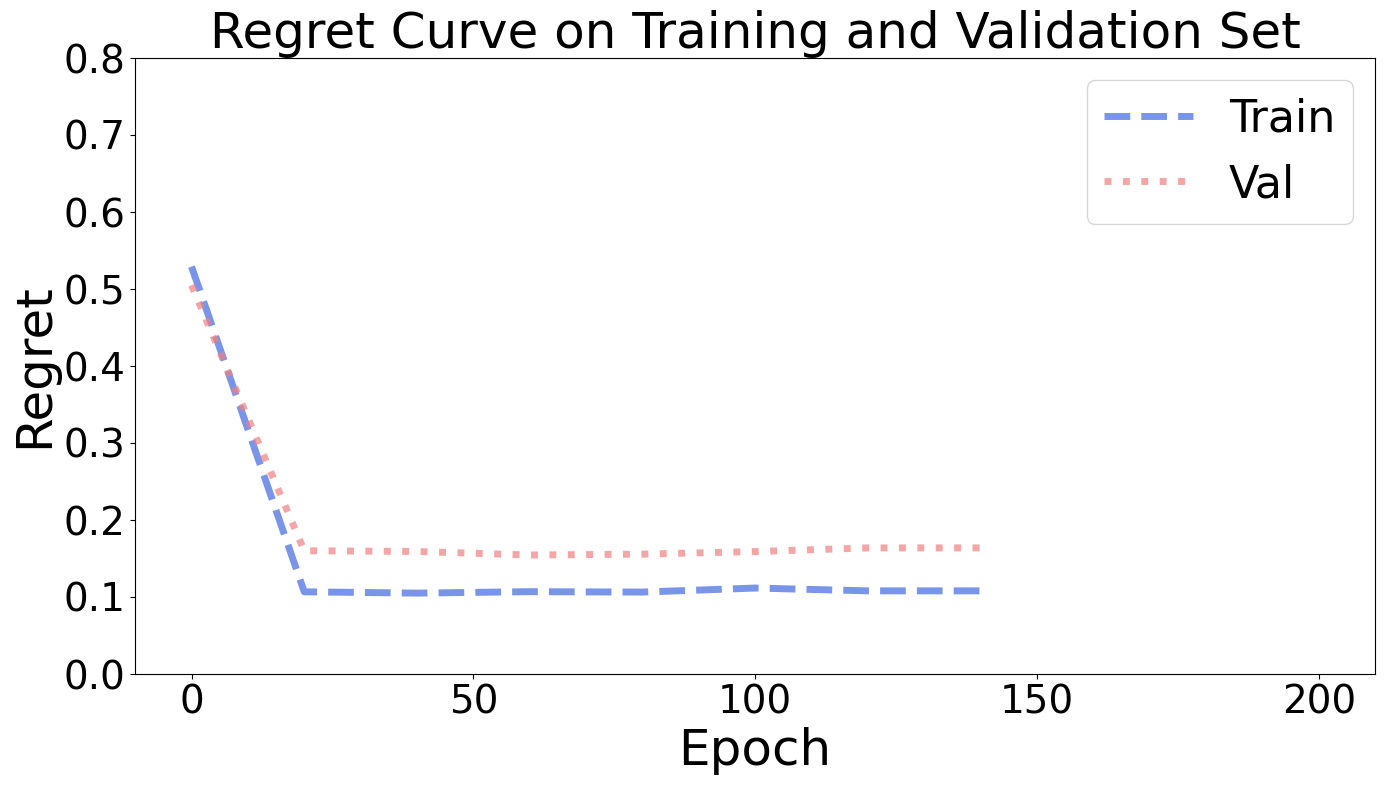

In [38]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)